In [ ]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import string
from tqdm import tqdm
tqdm.pandas()

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"vinodbarel","key":"20d0e66677df8bd148f305efd1611985"}'}

In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle dataset list

usage: kaggle [-h] [-v] {competitions,c,datasets,d,kernels,k,config} ...
kaggle: error: argument command: invalid choice: 'dataset' (choose from 'competitions', 'c', 'datasets', 'd', 'kernels', 'k', 'config')


In [ ]:
! kaggle datasets download -d ssismasterchief/machine-hack-fake-news-content-detection

machine-hack-fake-news-content-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip machine-hack-fake-news-content-detection.zip 

Archive:  machine-hack-fake-news-content-detection.zip
replace Test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Test.csv                
replace Train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ll
error:  invalid response [ll]
replace Train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Train.csv               
  inflating: sample submission.csv   


In [71]:
data = pd.read_csv("/content/Train.csv")

**Variable Description:**

Text - Raw content from social media/ new platforms

Text_Tag - Different types of content tags

Labels - Represents various classes of Labels
* Half-True - 2
* False - 1
* Mostly-True - 3
* True - 5
* Barely-True - 0
* Not-Known - 4

In [72]:
print(data.shape)
data.head()

(10240, 3)


,Labels,Text,Text_Tag
0,1,Says the Annies List political group supports ...,abortion
1,2,When did the decline of coal start? It started...,"energy,history,job-accomplishments"
2,3,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy
3,1,Health care reform legislation is likely to ma...,health-care
4,2,The economic turnaround started at the end of ...,"economy,jobs"


**Text Pre-processing**

In [76]:
import nltk
from nltk.stem import PorterStemmer  #
from nltk.corpus import stopwords

# Distribution of Target Variable

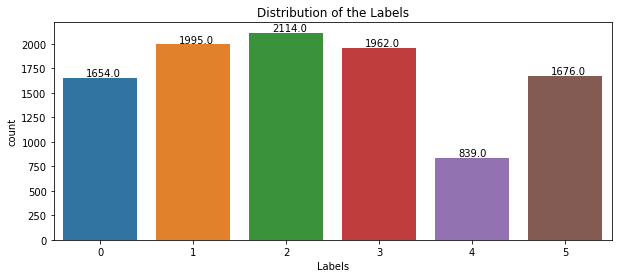

In [81]:
plt.figure(figsize = (10,4))
ax = sns.countplot(x="Labels", data=data)
for p in ax.patches:
    ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+15))
plt.title("Distribution of the Labels")
plt.show()

# Cleaning Text

In [82]:
data['Original Text'] = data['Text']

In [83]:
print("Original text: ")

print(data['Text'][0])

Original text: 
Says the Annies List political group supports third-trimester abortions on demand.


In [88]:
#lower case,
data["Text"] = data["Text"].str.lower()

In [85]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [86]:
stopwords_ = set(stopwords.words('english'))

def stopwords_removal(text):
    return " ".join([word for word in str(text).split() if word not in stopwords_])

tqdm.pandas()
data['Text'] = data['Text'].progress_apply(lambda text: stopwords_removal(text))

100%|██████████| 10240/10240 [00:00<00:00, 172176.10it/s]


In [87]:
print("After removing stopwords: ")

print(data['Text'][0])

After removing stopwords: 
says annies list political group supports third-trimester abortions demand.


In [ ]:
punctuations= list(string.punctuation)

def cleaning_punctuations(text):
    return text.translate(str.maketrans('', '', string.punctuation))

data['Text'] = data['Text'].progress_apply(lambda text: cleaning_punctuations(text))

100%|██████████| 10240/10240 [00:00<00:00, 162730.07it/s]


In [ ]:
print("After removing punctuations: ")

print(data['Text'][0])

After removing punctuations: 
says annies list political group supports thirdtrimester abortions demand


# Word Cloud for Fake News

In [ ]:
from wordcloud import WordCloud 

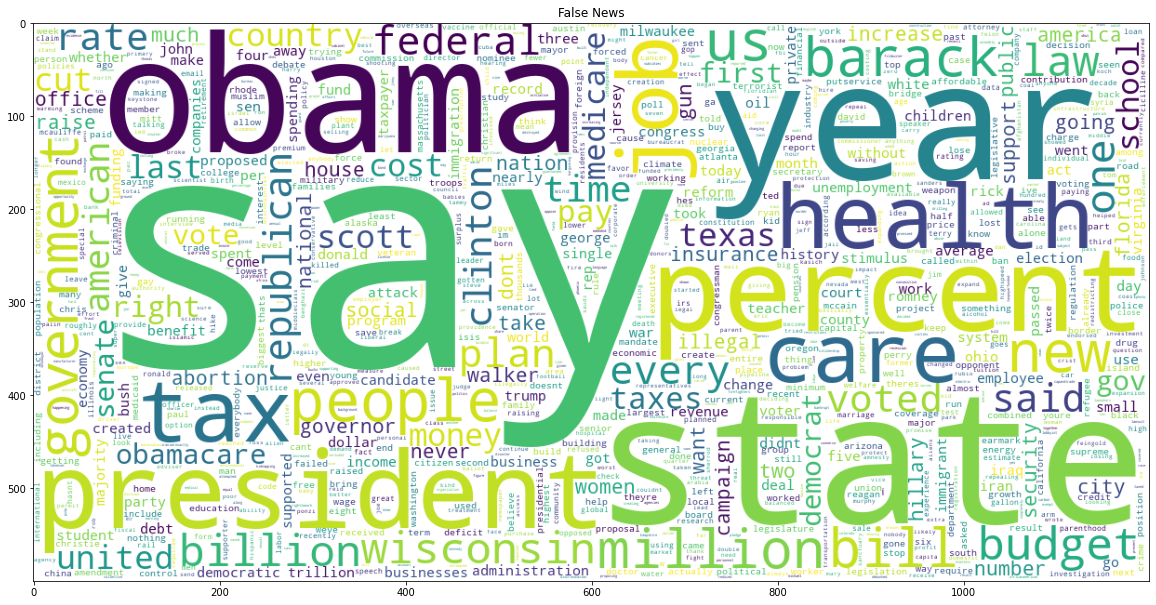

In [ ]:
wc = WordCloud(background_color='white', max_words = 1000 , width = 1200 , height = 600, 
               collocations=False).generate(" ".join(data[data['Labels']==1]['Text']))
plt.figure(figsize = (20,20))
plt.title("False News")
plt.imshow(wc)

# Data Preparation 

In [89]:
!pip install tensorflow-addons


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [90]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_addons as tfa

In [91]:
num_classes = (data['Labels'].nunique())

In [92]:
X = data['Text']
y = tf.keras.utils.to_categorical(data['Labels'], num_classes)

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [94]:
train_tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='<OOV>')
train_tokenizer.fit_on_texts(X_train.values)
train_word_index = train_tokenizer.word_index
#print(train_word_index)

In [95]:
train_tokenizer

In [96]:
vocab_length = len(train_word_index) + 1
vocab_length

11246

In [97]:
train_sequences = train_tokenizer.texts_to_sequences(X_train)
len(train_sequences)

8192

In [ ]:
test_sequences = train_tokenizer.texts_to_sequences(X_test)
len(test_sequences)

2048

In [ ]:
maxlen=20
train_padded_seqeunces = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, padding='post', maxlen=maxlen, truncating='post')
test_padded_seqeunces = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, padding='post', maxlen=maxlen, truncating='post')

# RNN Model

In [ ]:
embedding_dim = 6
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_length, embedding_dim, input_length=maxlen),
    tf.keras.layers.SimpleRNN(64, activation='tanh', return_sequences=True),
    tf.keras.layers.SimpleRNN(32, activation='tanh', return_sequences=True),
    tf.keras.layers.SimpleRNN(16, activation='tanh'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=tfa.metrics.F1Score(num_classes=num_classes))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 6)             72504     
                                                                 
 simple_rnn (SimpleRNN)      (None, 20, 64)            4544      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 20, 32)            3104      
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 16)                784       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dense_1 (Dense)             (None, 6)                 1

In [ ]:
history = model.fit(train_padded_seqeunces, y_train, epochs=20, validation_data=(test_padded_seqeunces, y_test))

Epoch 1/20
256/256 [==============================] - 7s 17ms/step - loss: 1.7767 - f1_score: 0.1488 - val_loss: 1.7603 - val_f1_score: 0.1081
Epoch 2/20
256/256 [==============================] - 4s 15ms/step - loss: 1.7422 - f1_score: 0.1753 - val_loss: 1.7624 - val_f1_score: 0.1596
Epoch 3/20
256/256 [==============================] - 4s 15ms/step - loss: 1.6545 - f1_score: 0.2696 - val_loss: 1.8570 - val_f1_score: 0.1599
Epoch 4/20
256/256 [==============================] - 4s 15ms/step - loss: 1.4416 - f1_score: 0.4101 - val_loss: 2.0367 - val_f1_score: 0.1882
Epoch 5/20
256/256 [==============================] - 4s 15ms/step - loss: 1.1789 - f1_score: 0.5557 - val_loss: 2.2412 - val_f1_score: 0.1888
Epoch 6/20
256/256 [==============================] - 4s 15ms/step - loss: 0.9382 - f1_score: 0.6663 - val_loss: 2.5679 - val_f1_score: 0.1868
Epoch 7/20
256/256 [==============================] - 6s 22ms/step - loss: 0.7294 - f1_score: 0.7489 - val_loss: 2.9495 - val_f1_score: 0.1735

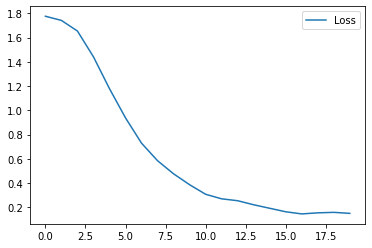

In [ ]:
plt.plot(history.history['loss'], label='Loss')

plt.legend()
plt.show()

In [ ]:
model.evaluate(test_padded_seqeunces, y_test)

64/64 [==============================] - 0s 5ms/step - loss: 5.4364 - f1_score: 0.1904


[5.436408042907715,
 array([0.1967213 , 0.2039801 , 0.1981982 , 0.19389111, 0.12256268,
        0.22677596], dtype=float32)]

In [ ]:
test_prob = model.predict(test_padded_seqeunces)
test_pred = np.where(test_prob > 0.5, 1, 0)

# Model Performance

In [ ]:
from sklearn.metrics import f1_score, log_loss, multilabel_confusion_matrix, plot_confusion_matrix

In [ ]:
print("Log-Loss =", log_loss(y_test, test_prob))

Log-Loss = 5.436409595520658


In [ ]:
print("F1-Score =", f1_score(y_test, test_pred, average = 'weighted'))

F1-Score = 0.1919166791206291


In [ ]:
labels = ['Barely-True', 'False', 'Half-True', 'Mostly-True', 'Not-Known', 'True']
cm = multilabel_confusion_matrix(y_test, test_pred)

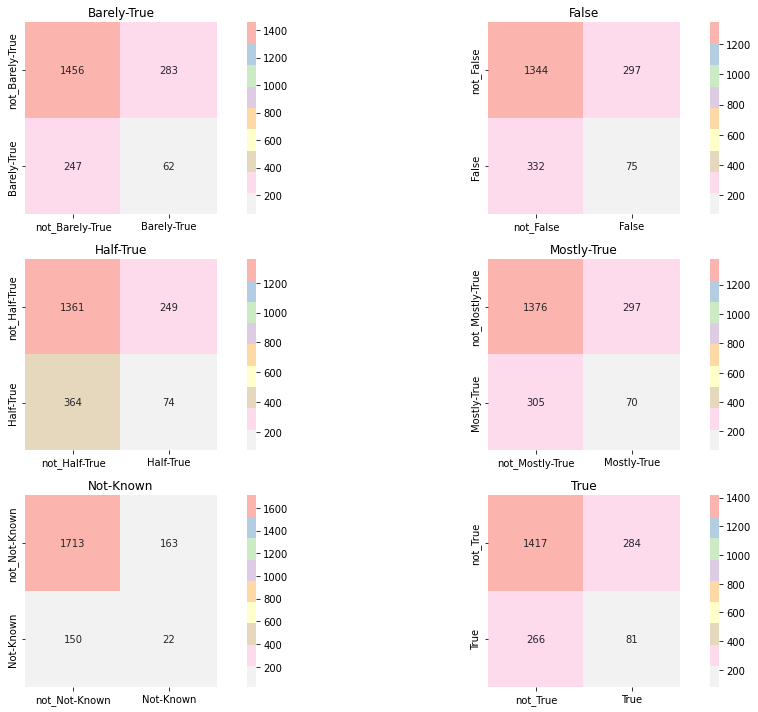

In [ ]:
fig = plt.figure(figsize = (15, 10))
for i, (label, matrix) in enumerate(zip(labels, cm)):
    plt.subplot(3, 2, i+1)
    l = [f'not_{label}', label]
    sns.heatmap(matrix, annot = True, square = True, xticklabels = l, yticklabels = l, cmap='Pastel1_r', fmt='d')
    plt.title(label)
    
plt.tight_layout()
plt.show()